In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 [==============================] - 0s 0us/step


In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
citations.sample(frac=1).head()

,target,source
5274,647315,1154076
3609,74427,1106771
2166,18777,33013
561,2354,1107140
630,2658,1130808


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
print(papers.sample(5).T)

                         1466             411     436              458   \
paper_id                98693            16485  711598          1114153   
term_0                      0                0       0                0   
term_1                      0                0       0                0   
term_2                      0                0       0                0   
term_3                      0                0       0                0   
...                       ...              ...     ...              ...   
term_1429                   0                0       0                0   
term_1430                   0                0       1                0   
term_1431                   0                0       1                0   
term_1432                   0                0       0                0   
subject    Genetic_Algorithms  Neural_Networks  Theory  Neural_Networks   

                    156   
paper_id         1153811  
term_0                 0  
term_1            

Let's display the count of the papers in each subject.

In [ ]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


We convert the paper ids and the subjects into zero-based indices.



In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Now let's visualize the citation graph. Each node in the graph represents a paper, and the color of the node corresponds to its subject. Note that we only show a sample of the papers in the dataset.

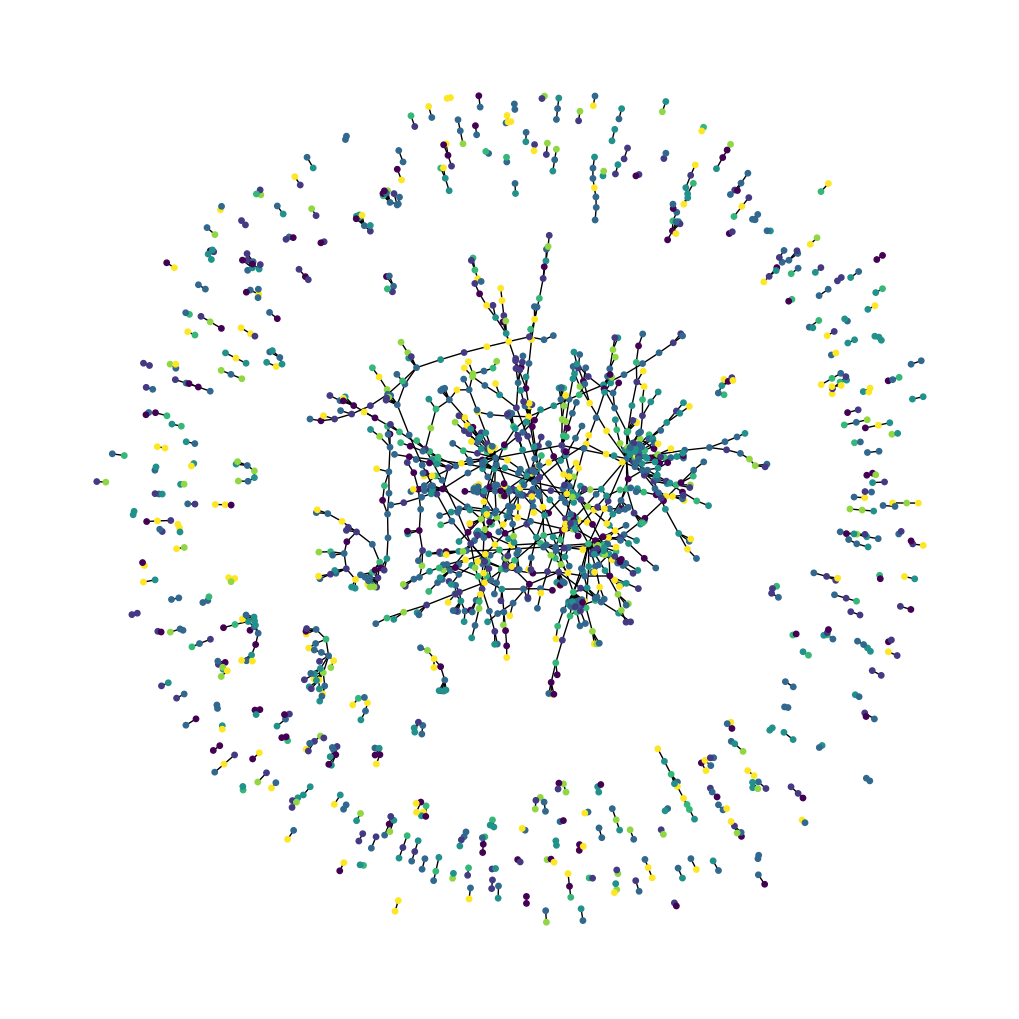

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

Split the dataset into stratified train and test sets


In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1345, 1435)
Test data shape: (1363, 1435)


Implement Train and Evaluate Experiment


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

This function compiles and trains an input model using the given training data.



In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

This function displays the loss and accuracy curves of the model during training.



In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

Implement Feedforward Network (FFN) Module


In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

Prepare the data for the baseline model


In [ ]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

We add five FFN blocks with skip connections, so that we generatee a baseline model with roughly the same number of parameters as the GNN models to be built later.

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

Train the baseline classifier


In [ ]:
history = run_experiment(baseline_model, x_train, y_train)


Epoch 1/300
5/5 [==============================] - 8s 167ms/step - loss: 3.7450 - acc: 0.1444 - val_loss: 1.9234 - val_acc: 0.2772
Epoch 2/300
5/5 [==============================] - 0s 31ms/step - loss: 2.8493 - acc: 0.2388 - val_loss: 1.8906 - val_acc: 0.1683
Epoch 3/300
5/5 [==============================] - 0s 33ms/step - loss: 2.3135 - acc: 0.2275 - val_loss: 1.8547 - val_acc: 0.2426
Epoch 4/300
5/5 [==============================] - 0s 32ms/step - loss: 2.1253 - acc: 0.2555 - val_loss: 1.8508 - val_acc: 0.3366
Epoch 5/300
5/5 [==============================] - 0s 32ms/step - loss: 2.0215 - acc: 0.2738 - val_loss: 1.8367 - val_acc: 0.3218
Epoch 6/300
5/5 [==============================] - 0s 46ms/step - loss: 1.8860 - acc: 0.3228 - val_loss: 1.7905 - val_acc: 0.3020
Epoch 7/300
5/5 [==============================] - 0s 40ms/step - loss: 1.8292 - acc: 0.3202 - val_loss: 1.7587 - val_acc: 0.3614
Epoch 8/300
5/5 [==============================] - 0s 44ms/step - loss: 1.6837 - acc: 0.3

Let's plot the learning curves.



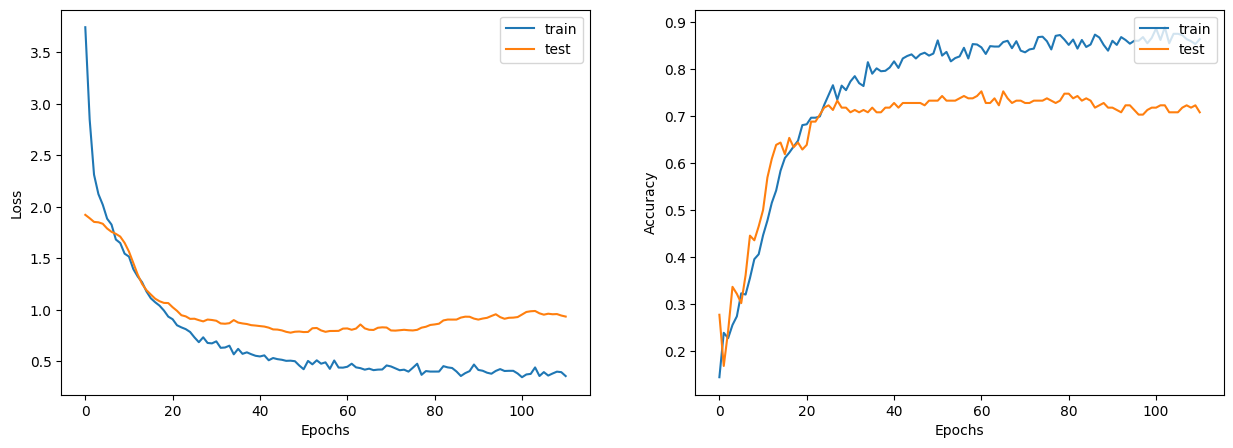

In [ ]:
display_learning_curves(history)
